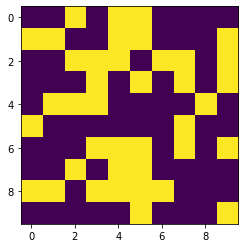

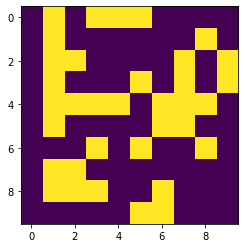

In [1]:
# 參考：用來生成 Game of Life 的下一個狀態，用來檢查
import numpy as np

# 先寫一個正常的程式，來生成 Game of Life 的下一個狀態，用來檢查
def game(board):
    board_pad = np.pad(board, 1, 'constant', constant_values = 0)
    # 用比較笨的方式，厲害一點用 http://stackoverflow.com/questions/32660953/numpy-sliding-2d-window-calculations
    rtn = np.zeros_like(board)
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            alive = board[i, j]
            neighbord_count = board_pad[i:i+3, j:j+3].sum() - alive
            if (alive and neighbord_count == 2) or neighbord_count==3:
                rtn[i,j] = 1
    return rtn

# 隨機生成一個盤面
board = np.random.randint(0,2, size=(10,10))
# 畫出來看看
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(0)
plt.imshow(board)

# 跑出下一個盤面
board_after = game(board)
# 畫出來看看
plt.figure(1)
plt.imshow(board_after);

## Using numpy

In [2]:
def conv2d(X, kernel, bias):
    
    convolved = np.zeros((kernel.shape[0], X.shape[0], X.shape[1]))
    
    # padding
    ud_pad = kernel.shape[1]-1
    rl_pad = kernel.shape[2]-1
    # up and down
    if (ud_pad%2==0):
        for i in range(int(ud_pad/2)):
            X = np.insert(X, 0, 0, axis=0)
            X = np.insert(X, X.shape[0], 0, axis=0)
    else:
        X = np.insert(X, X.shape[0], 0, axis=0)
        for i in range(int((ud_pad-1)/2)):
            X = np.insert(X, 0, 0, axis=0)
            X = np.insert(X, X.shape[0], 0, axis=0)
    # left and right
    if (rl_pad%2==0):
        for i in range(int(rl_pad/2)):
            X = np.insert(X, 0, 0, axis=1)
            X = np.insert(X, X.shape[1], 0, axis=1)
    else:
        X = np.insert(X, X.shape[1], 0, axis=1)
        for i in range(int((rl_pad-1)/2)):
            X = np.insert(X, 0, 0, axis=1)
            X = np.insert(X, X.shape[1], 0, axis=1)
    
    # convlution
    for n in range(kernel.shape[0]):
        for i in range(convolved.shape[1]):
            for j in range(convolved.shape[2]):
                convolved[n, i, j] = (X[i:i+kernel.shape[1], j:j+kernel.shape[2]] * kernel[n]).sum()+bias[n]
    
    # activation: ReLU
    convolved = np.maximum(convolved, 0)
                
    return convolved

In [3]:
N = 5
boards = np.random.randint(0,2, size=(N,10,10))

In [4]:
K1 = np.array([[[1, 1, 1],
                [1, 1, 1],
                [1, 1, 1]],
               [[1, 1, 1],
                [1, 1, 1],
                [1, 1, 1]],
               [[1, 1, 1],
                [1, 10, 1],
                [1, 1, 1]],
               [[1, 1, 1],
                [1, 10, 1],
                [1, 1, 1]]])
b1 = np.array([-2, -3, -12, -13])
K2 = np.array([[[1]],
               [[-2]],
               [[1]],
               [[-2]]])
b2 = np.array([-0.5])

OK 0
OK 1
OK 2
OK 3
OK 4


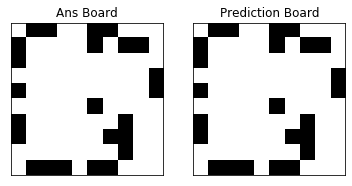

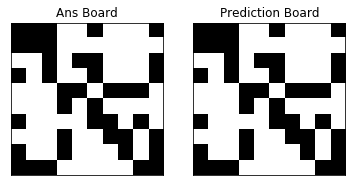

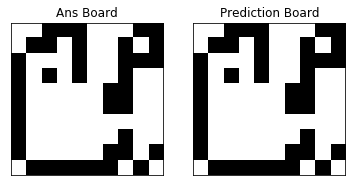

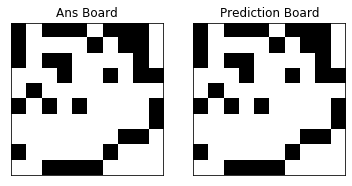

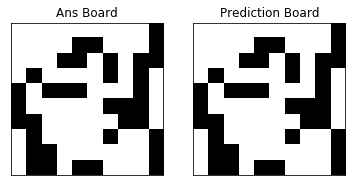

In [5]:
for i in range(N):
    # ans
    b = game(boards[i])
    
    # our method
    hidden = conv2d(boards[i], K1, b1)
    tmp = hidden * K2
    output = np.zeros((tmp.shape[1], tmp.shape[2]))
    for j in range(tmp.shape[0]):
        output = np.add(output, tmp[j])
    output = np.maximum(output, 0)
    
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(b, cmap='binary')
    plt.title('Ans Board'), plt.xticks([]), plt.yticks([])
    figure.add_subplot(1,2, 2)
    plt.imshow(output, cmap='binary')
    plt.title('Prediction Board'), plt.xticks([]), plt.yticks([])
    
    assert (b == output).all()
    print("OK", i)

## Using Keras

In [6]:
from keras.models import Model
from keras.layers import Conv2D, Input

def W(size, dtype='float32'):
    rtn = np.ones(shape=(3,3,1,4), dtype='float32')
    rtn[1,1,0,2:] = 10
    return rtn

def b(size, dtype='float32'):    
    return np.array([-2,-3, -12,-13], dtype=dtype)

def W2(size, dtype='float32'):
    return np.array([1,-2,1,-2], dtype=dtype).reshape(1,1,4,1)

def b2(size, dtype='float32'):
    return np.full(size, -0.5, dtype=dtype)

Using TensorFlow backend.


W1015 18:58:38.482291 139951870117696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



OK 0
OK 1
OK 2
OK 3
OK 4


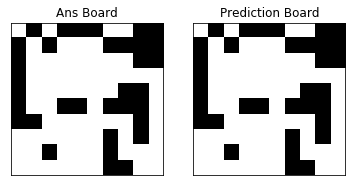

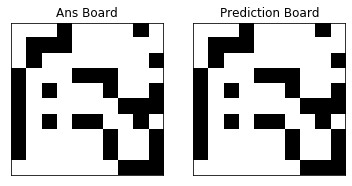

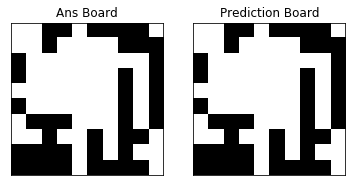

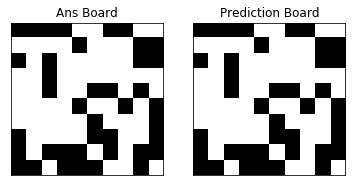

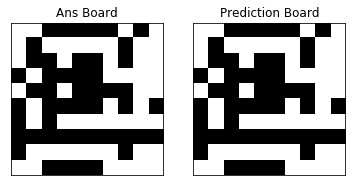

In [7]:
inputs = Input(shape=(None,None,1))
hidden = Conv2D(filters=4, kernel_size=3, padding='same', activation="relu",
             kernel_initializer=W, bias_initializer=b)(inputs)
out = Conv2D(filters=1, kernel_size=1, padding='same', activation="relu",
             kernel_initializer=W2, bias_initializer=b2)(hidden)
model = Model(inputs, out)

N = 5
boards = np.random.randint(0,2, size=(N,10,10))
rtn = model.predict(boards[..., None])
rtn = (rtn>0).astype('int')

for i in range(N):
    b = game(boards[i])
    
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(b, cmap='binary')
    plt.title('Ans Board'), plt.xticks([]), plt.yticks([])
    figure.add_subplot(1,2, 2)
    plt.imshow(rtn[i, :, :, 0], cmap='binary')
    plt.title('Prediction Board'), plt.xticks([]), plt.yticks([])
    
    assert (b == rtn[i, :, :, 0]).all()
    print("OK", i)

In [8]:
# 或者用動畫跑跑看 需要 pillow, ipywidgets
# 定義一個動畫的函數
from IPython.display import display
from ipywidgets import Image as Image_widget
import time
from PIL import Image
def anim(func, time_length, interval=0.1, width=400):
    img = Image_widget(width=width)
    display(img)
    start_time = time.time()
    for t in np.arange(0, time_length, interval):
        frame = Image.fromarray((func(t)*255).astype('uint8'))
        img.value = frame._repr_png_()
        now = time.time()
        if now < start_time+t:
            time.sleep(start_time+t-now)

# 下面跑 Game of Life 的動畫
board = np.random.randint(0,2, size=(100,100))
def glife(t):
    if t>0:
        board[...] = game(board)
    return board
# 一分鐘
anim(glife, 60)

Image(value=b'', width='400')